Building a simple cnn Arcchitecture

In [2]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- Define Model Parameters ---
# Let's assume our images will be resized to 64x64 pixels with 3 color channels (RGB)
IMG_HEIGHT = 64
IMG_WIDTH = 64
# Let's assume we have 10 fashion categories to predict
NUM_CLASSES = 10

# --- Build the CNN Model ---
model = keras.Sequential([
    # Input Layer: Specify the shape of our images
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    
    # First Convolutional Block 
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Second Convolutional Block
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten the 2D feature maps into a 1D vector
    layers.Flatten(),
    
    # A standard Dense layer for classification
    layers.Dense(128, activation='relu'),
    
    # Output Layer: NUM_CLASSES neurons with softmax for multi-class probability
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Print the model's summary to see how the data shape changes
model.summary()




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,626,442 (6.20 MB)

 Trainable params: 1,626,442 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

Formular for Convolutional layer = (input - kernel size + 1)
Formular for Max pooling layer = floor(input/pool size)

#### CNN Image classification

In [3]:
import os
import zipfile
import shutil
import pandas as pd

# ---------------- CONFIG ----------------
CLASSES = ["Garment Lower body", "Socks & Tights", "Underwear"]  # Classes to include
N_PER_CLASS = 10  # Number of images per class
ARTICLES_CSV = "../data/articles.csv"  # Path to your CSV file
ZIP_PATH = "../data/images.zip"  # Path to downloaded zip file
OUTPUT_DIR = "../data/cnn_data/"  # Directory where extracted images will be saved
# ----------------------------------------

# Create output directories for each class
os.makedirs(OUTPUT_DIR, exist_ok=True)  # Create root output folder if it doesn't exist
for c in CLASSES:
    os.makedirs(os.path.join(OUTPUT_DIR, c), exist_ok=True)  # Create subfolder per class

# Load CSV and filter for chosen classes
df = pd.read_csv(ARTICLES_CSV)  # Read articles CSV
df['product_group_name'] = df['product_group_name'].str.strip()  # Remove extra spaces
filtered = df[df['product_group_name'].isin(CLASSES)]  # Keep only rows for selected classes

# Select top N_PER_CLASS articles per class
selected = pd.DataFrame()  # Empty DataFrame to store selected articles
for c in CLASSES:
    subset = filtered[filtered['product_group_name'] == c].head(N_PER_CLASS)  # Take first N_PER_CLASS
    selected = pd.concat([selected, subset])  # Add to selection
selected = selected.reset_index(drop=True)  # Reset row indices

# Zero-pad article_ids to 10 digits to match zip filenames
selected['article_id'] = selected['article_id'].astype(str).str.zfill(10)

# Map article_id to its class
article_class_map = dict(zip(selected['article_id'], selected['product_group_name']))  # Dict: id -> class

# Set of article_ids we need
needed_ids = set(selected['article_id'])  # For quick lookup

# ----------------- Extraction -----------------
with zipfile.ZipFile(ZIP_PATH, 'r') as z:  # Open the zip file
    for member in z.namelist():  # Loop over all files inside the zip
        if not member.lower().endswith('.jpg'):
            continue  # Skip non-image files
        article_id = os.path.splitext(os.path.basename(member))[0]  # Get article ID from filename
        if article_id in needed_ids:  # Only extract if we need it
            cls = article_class_map[article_id]  # Get the class of this article
            dst = os.path.join(OUTPUT_DIR, cls, f"{article_id}.jpg")  # Destination path
            os.makedirs(os.path.dirname(dst), exist_ok=True)  # Ensure folder exists
            with z.open(member) as source, open(dst, "wb") as target:  # Open source & destination
                shutil.copyfileobj(source, target)  # Copy image content

# ----------------- Report -----------------
for c in CLASSES:
    cnt = len([f for f in os.listdir(os.path.join(OUTPUT_DIR, c)) if f.lower().endswith('.jpg')])
    print(f"{c}: {cnt} images copied to {os.path.join(OUTPUT_DIR, c)}")  # Print how many images copied per class


Garment Lower body: 10 images copied to ../data/cnn_data/Garment Lower body
Socks & Tights: 10 images copied to ../data/cnn_data/Socks & Tights
Underwear: 10 images copied to ../data/cnn_data/Underwear


#### Preparing dataset for training,validation and also parameters


In [4]:
import tensorflow as tf  # Import TensorFlow library

# ---------------- Image & dataset parameters ----------------
IMG_HEIGHT = 64  # Height to resize all images to
IMG_WIDTH = 64   # Width to resize all images to
BATCH_SIZE = 32  # Number of images per batch during training
DATA_DIR = '../data/cnn_data/'  # Root folder where your class subfolders are

# ---------------- Create the training dataset ----------------
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,               # Directory containing subfolders per class
    validation_split=0.2,   # Reserve 20% of data for validation
    subset="training",      # Specify this dataset is the training portion
    seed=123,               # Random seed for reproducibility (ensures same split every run)
    image_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize all images to uniform size
    batch_size=BATCH_SIZE   # Number of images per batch
)

# ---------------- Create the validation dataset ----------------
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,               # Same directory as training
    validation_split=0.2,   # Same split percentage
    subset="validation",    # Specify this dataset is the validation portion
    seed=123,               # Same seed to ensure split matches training
    image_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize images to same size as training
    batch_size=BATCH_SIZE   # Same batch size as training
)


Found 30 files belonging to 3 classes.
Using 24 files for training.


Found 30 files belonging to 3 classes.
Using 6 files for validation.


#### Preparation and Training

In [8]:
model.compile(
    optimizer='adam',  # Specifies the optimization algorithm used to update model weights (Adam is fast and commonly used)
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  
        # Defines the loss function to measure how well the model predicts labels
        # 'SparseCategoricalCrossentropy' is used when labels are integers (not one-hot encoded)
        # 'from_logits=True' means the model's output layer does NOT have a softmax; loss will apply softmax internally
    metrics=['accuracy']  # Metric to track during training; here we monitor accuracy of predictions
)


print("Starting CNN training...")  
# Displays a message indicating that model training is about to begin

history = model.fit(
    train_ds,               # The training dataset containing input images and labels
    validation_data=val_ds, # The validation dataset used to evaluate performance after each epoch
    epochs=5                # Number of times the model will go through the entire training dataset
)
# 'model.fit' trains the CNN on the training data and tracks performance on validation data
# Returns a 'history' object containing training and validation loss and accuracy per epoch


Starting CNN training...
Epoch 1/5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8750 - loss: 3.7351 - val_accuracy: 0.3333 - val_loss: 117.8286
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.3333 - loss: 199.4904 - val_accuracy: 0.6667 - val_loss: 68.8411
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.3333 - loss: 132.9382 - val_accuracy: 0.6667 - val_loss: 15.9143
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.6250 - loss: 23.0943 - val_accuracy: 0.5000 - val_loss: 7.7585
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.7083 - loss: 5.2675 - val_accuracy: 0.6667 - val_loss: 7.9573


#### Boosting Performance  with Transfer Learning

In [9]:
import tensorflow as tf  # Import TensorFlow for deep learning

# Reuse constants from before
IMG_HEIGHT = 64  # Height of input images (must match pre-trained model's expected size)
IMG_WIDTH = 64   # Width of input images
NUM_CLASSES = 3  # Number of target categories (e.g., Dresses, Upper body, Underwear)

# -------------------- Task 1: Load Pre-trained Base Model --------------------
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),  # Shape of input images (H, W, 3 for RGB)
    include_top=False,                       # Remove the original ImageNet classification head
    weights='imagenet'                        # Load weights pre-trained on ImageNet dataset
)  # This gives us a powerful feature extractor without retraining from scratch

# -------------------- Task 2: Freeze the Base Model --------------------
base_model.trainable = False  # Keep pre-trained weights fixed so they don’t get updated during training

# -------------------- Task 3: Build the New Model --------------------
model_transfer = tf.keras.Sequential([
    base_model,                                # Use frozen pre-trained CNN as the feature extractor
    tf.keras.layers.GlobalAveragePooling2D(),  # Convert feature maps to a single vector by averaging each feature map
    tf.keras.layers.Dense(NUM_CLASSES)         # Final dense layer to classify into our custom categories
])  # This stack lets us reuse old knowledge and just learn the mapping to our new labels

# Show model details
model_transfer.summary()  # Displays number of trainable vs non-trainable parameters

# -------------------- Task 4: Compile the Model --------------------
model_transfer.compile(
    optimizer='adam',  # Adam optimizer adapts learning rate for faster convergence
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Loss for integer class labels
    metrics=['accuracy']  # Track accuracy during training
)

# -------------------- Task 5: Train the Model --------------------
epochs = 10  # More epochs since training will be faster with frozen layers
history_transfer = model_transfer.fit(
    train_ds,              # Training dataset
    epochs=epochs,         # Number of passes through the dataset
    validation_data=val_ds # Validation dataset to monitor generalization
)  # We expect faster accuracy improvement compared to training a CNN from scratch


C:\Users\hp\AppData\Local\Temp\ipykernel_21544\476013090.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.2500 - loss: 2.1745 - val_accuracy: 0.1667 - val_loss: 1.6061
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2083 - loss: 1.7750 - val_accuracy: 0.1667 - val_loss: 1.4776
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.1667 - loss: 1.4328 - val_accuracy: 0.1667 - val_loss: 1.4540
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.3333 - loss: 1.1858 - val_accuracy: 0.1667 - val_loss: 1.5574
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.4167 - loss: 1.0503 - val_accuracy: 0.1667 - val_loss: 1.7113
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step - accuracy: 0.4583 - loss: 0.9901 - val_accuracy: 0.1667 - val_loss: 1.8167
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.4167 - loss: 0.9462 - val_accuracy: 0.1667 - val_loss: 1.8328
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.4167 - loss: 0.8854 - val_accuracy: 0.1667 - val_loss: 1.

#### Using Functional API

In [21]:
import tensorflow as tf  # Import TensorFlow for deep learning

# -------------------- Constants --------------------
IMG_HEIGHT = 64  # Height of input images
IMG_WIDTH = 64   # Width of input images
NUM_CLASSES = 3  # Target categories (e.g., Dresses, Upper body, Underwear)

# -------------------- Task 1: Load Pre-trained Base Model --------------------
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),  # Input shape (H, W, 3 channels)
    include_top=False,                       # Exclude original ImageNet classifier
    weights='imagenet'                        # Load pre-trained weights
)

# -------------------- Task 2: Freeze Base Model --------------------
base_model.trainable = False  # Lock weights to preserve learned features

# -------------------- Task 3: Build the New Model (Functional API) --------------------
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))  # Explicit input tensor
x = base_model(inputs, training=False)                     # Pass input through frozen base
x = tf.keras.layers.GlobalAveragePooling2D(name='gap_layer')(x)            # Convert feature maps to vector
outputs = tf.keras.layers.Dense(NUM_CLASSES)(x)            # New classifier layer for custom labels
model_transfer = tf.keras.Model(inputs, outputs)           # Complete model

# -------------------- Task 4: Compile the Model --------------------
model_transfer.compile(
    optimizer='adam',  # Adaptive optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Integer labels
    metrics=['accuracy']  # Track accuracy
)

# -------------------- Task 5: Train the Model --------------------
epochs = 10
history_transfer = model_transfer.fit(
    train_ds,              # Training dataset
    epochs=epochs,
    validation_data=val_ds # Validation dataset
)


C:\Users\hp\AppData\Local\Temp\ipykernel_21544\226529826.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.2500 - loss: 1.3500 - val_accuracy: 0.5000 - val_loss: 0.8867
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.5000 - loss: 1.1669 - val_accuracy: 0.5000 - val_loss: 0.9022
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5000 - loss: 1.0430 - val_accuracy: 0.6667 - val_loss: 0.8770
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.5833 - loss: 0.9359 - val_accuracy: 0.6667 - val_loss: 0.8253
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.6250 - loss: 0.8355 - val_accuracy: 0.6667 - val_loss: 0.7631
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.6667 - loss: 0.7420 - val_accuracy: 0.6667 - val_loss: 0.7007
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.7083 - loss: 0.6567 - val_accuracy: 0.5000 - val_loss: 0.6448
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.7500 - loss: 0.5802 - val_accuracy: 0.6667 - val_loss: 0.

#### “Building a Visual Product Recommender Using Transfer Learning and Feature Embeddings(Classification to Visual Recommendations)”

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap_layer                       │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

Generating embeddings...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Shape of embeddings matrix: (24, 1280)


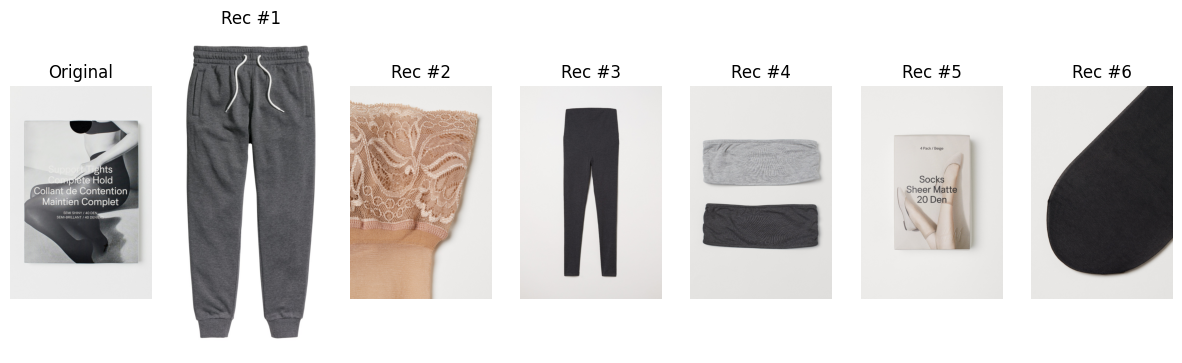

In [22]:
import tensorflow as tf   # Core deep learning framework for building and using the model
import numpy as np        # Numerical computing library, used for arrays, random selection, etc.
import matplotlib.pyplot as plt  # Plotting library for visualizing results
import matplotlib.image as mpimg # For reading image files into arrays for display
from sklearn.metrics.pairwise import cosine_similarity  # Function to compute similarity between vectors

# ----------------------------
# PREREQUISITES:
# - 'model_transfer' is an already trained transfer learning model
# - 'train_ds' is the dataset object used to train it
# This script transforms the trained model into a feature extractor,
# generates embeddings, and uses them for image recommendations.
# ----------------------------


# ===== Task 1: Create Feature Extractor =====
feature_extractor = tf.keras.Model(
    inputs=model_transfer.input,  # Use the same image input format as the original trained model
    outputs=model_transfer.get_layer('gap_layer').output
    # Instead of outputting final class predictions, we stop at the
    # GlobalAveragePooling2D layer → gives us a compact "embedding vector"
    # that represents the learned features of the image.
)

feature_extractor.summary()  # Prints the architecture → confirms output layer is the GAP layer
# This also shows that most parameters are "Non-trainable" since we're not re-training.

# ===== Task 2: Generate Embeddings =====
image_paths = train_ds.file_paths  # Get absolute file paths for each image in the dataset
# This is crucial for displaying recommendations later since predictions alone are just numbers.

print("Generating embeddings...")
image_embeddings = feature_extractor.predict(train_ds)  
# Pass every image through the feature extractor model
# Output: matrix of embeddings → each row is an image, each column is a learned feature value
print(f"Shape of embeddings matrix: {image_embeddings.shape}")
# Shape example: (5000, 1280) → 5000 images, each turned into a 1280-length feature vector

# ===== Task 3: Build Recommendation Function =====
def get_visual_recommendations(target_embedding, all_embeddings, all_paths, n=6):
    """
    Finds the N most visually similar images in the dataset using cosine similarity.
    
    Cosine similarity measures the angle between two vectors — smaller angles = more similar.
    This works well for embeddings because their magnitude doesn't matter, only their direction.
    """
    target_embedding = target_embedding.reshape(1, -1)  
    # Reshape 1D vector into shape (1, vector_length) → required by cosine_similarity

    sim_scores = cosine_similarity(target_embedding, all_embeddings)  
    # Compare target image's vector to every image vector in the dataset
    # Output: similarity score between -1 and 1 (1 means identical)

    sim_scores = list(enumerate(sim_scores[0]))  
    # Attach dataset index to each similarity score: [(index, score), ...]

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)  
    # Sort by similarity score from highest → lowest

    top_indices = [i[0] for i in sim_scores[1:n+1]]  
    # Take top N matches, skipping the first one (index 0 in sorted list)
    # because that's the query image itself (similarity = 1)

    return [all_paths[i] for i in top_indices]  
    # Convert top indices into actual file paths for the most similar images

# ===== Task 4: Test the Recommender =====
test_index = np.random.randint(0, len(image_paths))  
# Randomly select one image from dataset to act as the "query"

test_embedding = image_embeddings[test_index]  
# Grab the embedding vector for that query image
test_path = image_paths[test_index]  
# Get its file path so we can display the actual picture

recs = get_visual_recommendations(test_embedding, image_embeddings, image_paths)  
# Run recommendation function → returns N similar images based on vector comparison

# ===== Visualization =====
plt.figure(figsize=(15, 5))  
# Create a wide plotting canvas → enough space for original + N recommendations

plt.subplot(1, 7, 1)  
# Create first subplot position for original image (1 row, 7 columns, position 1)
plt.imshow(mpimg.imread(test_path))  
# Load and display original image
plt.title("Original")  
# Label the image
plt.axis('off')  
# Remove axis ticks and labels for cleaner visualization

# Loop through recommended images and plot them
for i, rec_path in enumerate(recs):
    plt.subplot(1, 7, i + 2)  
    # Start placing them from position 2 to position N+1
    plt.imshow(mpimg.imread(rec_path))  
    # Load each recommended image
    plt.title(f"Rec #{i+1}")  
    # Title them in order
    plt.axis('off')  
    # Keep visuals clean without axes

plt.show()  
# Render the figure with all images side by side
